In [1]:
"""Import all the necessary packages"""
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
"""Test for GPU or CPU devices"""
print("Device: \n", tf.config.experimental.list_physical_devices())
print(tf.__version__)
print(tf.test.is_built_with_cuda())

Device: 
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
2.8.0
True


In [3]:
"""Contrast Limited Adaptive Histogram Equalization (CLAHE) Method for preprocessing"""
def clahe_function(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    'Apply CLAHE on green channel of RGB image'
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    r, green, blue = cv2.split(rgb_img)
    
    clahe_img = clahe.apply(green)
    CLAHE_img = cv2.merge((r, clahe_img, blue))
   
    CLAHE_img = cv2.cvtColor(CLAHE_img, cv2.COLOR_RGB2BGR)
    'apply CLAHE on LAB image'
    '''
    lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l,a,b = cv2.split(lab_img)
    
    clahe_img = clahe.apply(l)
    updated_lab_img2 = cv2.merge((clahe_img, a, b))
    CLAHE_img = cv2.cvtColor(updated_lab_img2, cv2.COLOR_LAB2BGR)
    '''
    return CLAHE_img

In [4]:
"""Funcntion for loading images"""
images = []
def load_images_from_folder(folder):
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        #plt.imshow(img)
        #break
        #img = cv2.resize(img, (224, 224))
        img = clahe_function(img)
        img = img/255.0
        img = cv2.resize(img, (224, 224))
        if img is not None:
            images.append(img)

In [5]:
cataract = r'./Final_dataset_Cataract/Dataset/Cataract/'   # directory of cataract image
normal = r'./Final_dataset_Cataract/Dataset/Normal/'    # directory of normal image

In [6]:
len(os.listdir(cataract))

902

In [7]:
len(os.listdir(normal))

1162

In [8]:
load_images_from_folder(cataract)
load_images_from_folder(normal)

In [9]:
y = np.ones(902)  #labeling cataact images as 1
y = np.append(y, np.zeros(1162))   #labeling normal images as 0
y = list(y)
c = list(zip(images, y))

In [10]:
#reshuffling all the images along with their labels

random.shuffle(c)
images, y = zip(*c)
del c  #For Memory Efficiency
images = np.array(images)
y = np.array(y)

In [11]:
y.shape

(2064,)

1.0


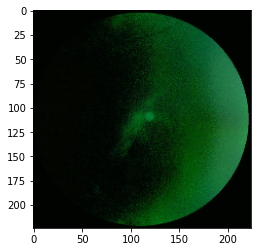

In [12]:
plt.imshow(images[0], cmap='gray')
print(y[0])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.15, stratify= y, random_state =2)

In [40]:
print('Total Training images',X_train.shape, y_train.shape)
print('Total Test images', X_test.shape, y_test.shape)

Total Training images (1754, 224, 224, 3) (1754,)
Total Test images (310, 224, 224, 3) (310,)


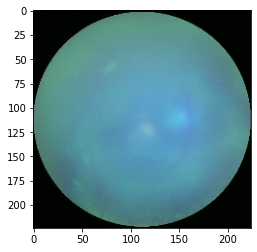

In [41]:
plt.imshow(X_train[0])

In [42]:
y_train[0]

1.0

In [43]:
"""Our proposed Convolutional Model for extracting features"""

model = tf.keras.Sequential()
#1st conv layer
model.add(tf.keras.layers.Conv2D(32, (3,3), input_shape=(224, 224, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.MaxPooling2D(2,2))
#2nd conv layer
model.add(tf.keras.layers.Conv2D(32, (3,3), padding="valid"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.MaxPooling2D(2,2))
#3rd conv layer 
model.add(tf.keras.layers.Conv2D(64, (3,3), padding="valid"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
#4th conv layer
model.add(tf.keras.layers.Conv2D(128, (3,3), padding="valid"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.MaxPooling2D(2,2))
#Flatten Layer
model.add(tf.keras.layers.Flatten())
#Dense Layer 1
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.Dropout(0.5))
#Dense Layer 2
model.add(tf.keras.layers.Dense(100,name ='feature_100')) #100 Prominant Features are Extracted From This Layer
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.Dropout(0.5))
#output Dense Layer
model.add(tf.keras.layers.Dense(2))
model.add(tf.keras.layers.Activation('sigmoid'))
adam = tf.keras.optimizers.Adam(lr=0.001)

model.compile(loss='sparse_categorical_crossentropy', metrics=['acc'], optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_6 (Batc  (None, 222, 222, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 batch_normalization_7 (Batc  (None, 109, 109, 32)    

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [44]:
#CNN Model Trained
with tf.device('/GPU:0'):
    history = model.fit(X_train, y_train, batch_size= 32, epochs=100, verbose=1,
                        validation_data=(X_test, y_test))

""" Save the model """
model.save("./model/cataract-NET.h5")

Epoch 1/100
55/55 [==============================] - 99s 1s/step - loss: 0.5291 - acc: 0.7583 - val_loss: 1.0185 - val_acc: 0.4355
Epoch 2/100
55/55 [==============================] - 71s 1s/step - loss: 0.3246 - acc: 0.8677 - val_loss: 1.7878 - val_acc: 0.4355
Epoch 3/100
55/55 [==============================] - 70s 1s/step - loss: 0.2849 - acc: 0.8820 - val_loss: 2.3102 - val_acc: 0.4355
Epoch 4/100
55/55 [==============================] - 69s 1s/step - loss: 0.2318 - acc: 0.9071 - val_loss: 2.8832 - val_acc: 0.4355
Epoch 5/100
55/55 [==============================] - 70s 1s/step - loss: 0.2189 - acc: 0.9196 - val_loss: 2.7933 - val_acc: 0.4355
Epoch 6/100
55/55 [==============================] - 70s 1s/step - loss: 0.2195 - acc: 0.9213 - val_loss: 2.1187 - val_acc: 0.4355
Epoch 7/100
55/55 [==============================] - 70s 1s/step - loss: 0.1892 - acc: 0.9247 - val_loss: 1.3820 - val_acc: 0.4419
Epoch 8/100
55/55 [==============================] - 69s 1s/step - loss: 0.1797 - a

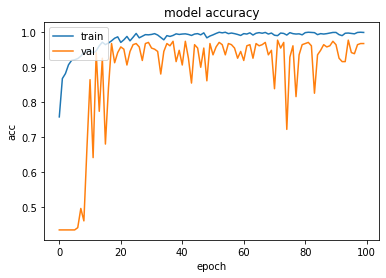

In [45]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

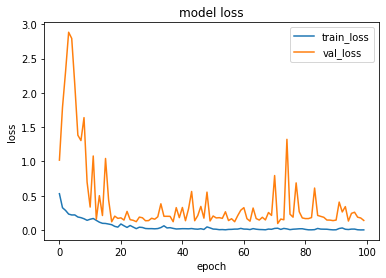

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper right')
plt.show()

In [47]:
loss, acc = model.evaluate(X_test, y_test, batch_size=16)

print("Accuracy: " ,acc*100)
print("Loss: ", loss)

20/20 [==============================] - 2s 120ms/step - loss: 0.1391 - acc: 0.9677
Accuracy:  96.77419066429138
Loss:  0.13908112049102783


In [14]:
""" Load the model """
model = tf.keras.models.load_model('./model/cataract-NET.h5')
intermediate_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('feature_100').output)
intermediate_layer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4_input (InputLayer)  [(None, 224, 224, 3)]    0         
                                                                 
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_6 (Batc  (None, 222, 222, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 32)      9248  

In [18]:
"""Features Extraction From All Images"""
feature_engg_data = intermediate_layer_model.predict(images)
feature_engg_data = pd.DataFrame(feature_engg_data)

In [51]:
"""Save The Features"""
feature_engg_data.to_pickle('./model/features/finalfeaturescataract2.pkl')
#features = pd.read_pickle('./model/features/finalfeaturescataract2.pkl')

In [52]:
features = pd.read_pickle('./model/features/finalfeaturescataract2.pkl')

In [53]:
features.head(5)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.849361,-0.975496,0.056623,0.509786,-1.590386,-1.225463,-0.377156,1.177474,0.742892,-0.309254,...,0.375384,0.772694,0.364725,0.339929,1.379419,1.450194,-0.808643,0.706944,0.981956,0.620570
1,-0.534249,-0.230232,1.016336,0.996429,-1.109883,-0.864239,-0.680602,1.154455,0.148939,0.618355,...,0.487187,0.665962,0.693780,0.304302,-0.375381,1.115950,-0.362185,0.912011,0.384253,-0.156683
2,-2.646253,-2.981815,3.883333,2.896121,-1.386964,-2.488221,-1.841081,-0.704039,2.591078,0.109292,...,2.494396,1.837179,2.061888,2.899512,1.038319,1.375245,-2.108646,2.313927,2.323139,1.261010
3,2.767592,2.623080,-2.298358,-3.014045,3.068618,2.485229,3.090087,-1.591780,-2.657461,-1.937473,...,-1.387367,-2.847111,-1.620335,-3.695590,-1.722631,-2.660573,2.338910,-3.104393,-2.264595,-1.223205
4,2.214126,2.083397,-1.926084,-2.488558,2.387969,2.093736,2.444782,-0.775574,-1.991013,-1.395011,...,-1.093308,-2.405725,-0.605719,-2.900753,-1.250830,-1.905439,1.477373,-2.362689,-1.867277,-1.166817


In [19]:
"""Normalization of The Features"""
from sklearn.preprocessing import StandardScaler
x = feature_engg_data.loc[:, feature_engg_data.columns].values
x = StandardScaler().fit_transform(x)

In [76]:
""" Load the model """
model = tf.keras.models.load_model('./model/cataract-NET.h5')
intermediate_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('feature_100').output)
intermediate_layer_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4_input (InputLayer)  [(None, 224, 224, 3)]    0         
                                                                 
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_6 (Batc  (None, 222, 222, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 32)      9248

In [77]:
"""Features Extraction From All Images"""
feature_engg_data = intermediate_layer_model.predict(images)
feature_engg_data = pd.DataFrame(feature_engg_data)

In [78]:
"""Normalization of The Features"""
from sklearn.preprocessing import StandardScaler
x = feature_engg_data.loc[:, feature_engg_data.columns].values
x = StandardScaler().fit_transform(x)

In [20]:
"""Splitting the Data into Training & Testing Set"""
X_train, X_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.15, 
                                                    stratify= y,
                                                    random_state =0)

(array([0., 0., 1.]), array([0.        , 0.99259259, 1.        ]), array([2., 1., 0.]))
[[175   0]
 [  1 134]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


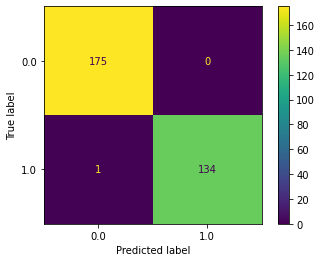

In [21]:
"""Gaussian Naive Bayes"""

from sklearn.naive_bayes import GaussianNB
from sklearn import  metrics
model = GaussianNB()
model.fit(X_train, y_train)
y_pred1 = model.predict(X_test)
metrics.accuracy_score(y_test, y_pred1)
print(metrics.roc_curve(y_test, y_pred1))
print(metrics.confusion_matrix(y_test, y_pred1))
cm= metrics.plot_confusion_matrix(model, X_test, y_test)
cm.figure_.savefig('conf_mat.png',dpi=300)

In [22]:
print ('Accuracy:', accuracy_score(y_test, y_pred1))
print ('F1 score:', f1_score(y_test, y_pred1))
print ('Recall:', recall_score(y_test, y_pred1))
print ('Precision:', precision_score(y_test, y_pred1))

NameError: name 'accuracy_score' is not defined

(array([0., 0., 1.]), array([0.        , 0.99259259, 1.        ]), array([2., 1., 0.]))
[[175   0]
 [  1 134]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       175
         1.0       1.00      0.99      1.00       135

    accuracy                           1.00       310
   macro avg       1.00      1.00      1.00       310
weighted avg       1.00      1.00      1.00       310



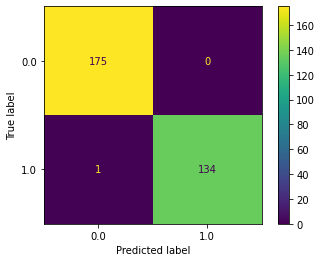

In [98]:
"""Gaussian Naive Bayes"""

from sklearn.naive_bayes import GaussianNB
from sklearn import  metrics
model = GaussianNB()
model.fit(X_train, y_train)
y_pred1 = model.predict(X_test)
metrics.accuracy_score(y_test, y_pred1)
print(metrics.roc_curve(y_test, y_pred1))
print(metrics.confusion_matrix(y_test, y_pred1))
cm= metrics.plot_confusion_matrix(model, X_test, y_test)
cm.figure_.savefig('conf_mat.png',dpi=300)
print(metrics.classification_report(y_test, y_pred1))

In [23]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report,accuracy_score, f1_score
print ('Accuracy:', accuracy_score(y_test, y_pred1))
print ('F1 score:', f1_score(y_test, y_pred1))
print ('Recall:', recall_score(y_test, y_pred1))
print ('Precision:', precision_score(y_test, y_pred1))

Accuracy: 0.9967741935483871
F1 score: 0.996282527881041
Recall: 0.9925925925925926
Precision: 1.0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


[[173   2]
 [  1 134]]
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       175
         1.0       0.99      0.99      0.99       135

    accuracy                           0.99       310
   macro avg       0.99      0.99      0.99       310
weighted avg       0.99      0.99      0.99       310



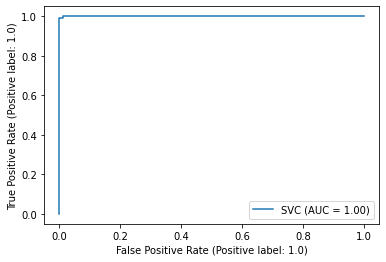

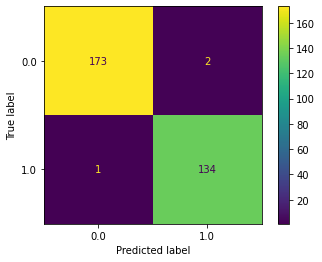

In [31]:
"""Support Vector Machine"""
from sklearn import  metrics
from sklearn.svm import SVC
svclassifier = SVC(kernel='sigmoid', probability=True)
svclassifier.fit(X_train, y_train)
y_pred2 = svclassifier.predict(X_test)
metrics.accuracy_score(y_test, y_pred2)
metrics.plot_roc_curve(svclassifier, X_test, y_test)
cm= metrics.plot_confusion_matrix(svclassifier, X_test, y_test)
cm.figure_.savefig('svm.png',dpi=300)
print(metrics.confusion_matrix(y_test, y_pred2))
print(metrics.classification_report(y_test, y_pred2))

In [32]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report,accuracy_score, f1_score
print ('Accuracy:', accuracy_score(y_test, y_pred2))
print ('F1 score:', f1_score(y_test, y_pred2))
print ('Recall:', recall_score(y_test, y_pred2))
print ('Precision:', precision_score(y_test, y_pred2))

Accuracy: 0.9903225806451613
F1 score: 0.988929889298893
Recall: 0.9925925925925926
Precision: 0.9852941176470589


0.9967741935483871
[[175   0]
 [  1 134]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       175
         1.0       1.00      0.99      1.00       135

    accuracy                           1.00       310
   macro avg       1.00      1.00      1.00       310
weighted avg       1.00      1.00      1.00       310



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


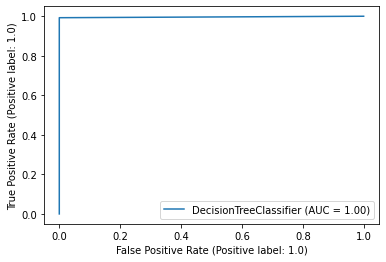

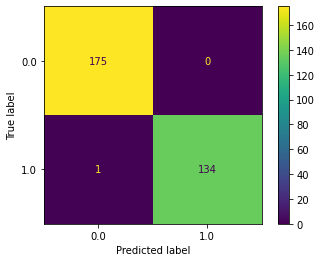

In [24]:
"""Decision Tree Classifier"""

from sklearn import tree
dt = tree.DecisionTreeClassifier()
dt = dt.fit(X_train, y_train)

y_pred3 = dt.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred3))
metrics.roc_curve(y_test, y_pred3)
metrics.plot_roc_curve(dt, X_test, y_test)
cm= metrics.plot_confusion_matrix(dt, X_test, y_test)
print(metrics.confusion_matrix(y_test, y_pred3))
print(metrics.classification_report(y_test, y_pred3))
cm.figure_.savefig('DT.png',dpi=300)

In [25]:
print ('Accuracy:', accuracy_score(y_test, y_pred3))
print ('F1 score:', f1_score(y_test, y_pred3))
print ('Recall:', recall_score(y_test, y_pred3))
print ('Precision:', precision_score(y_test, y_pred3))

Accuracy: 0.9967741935483871
F1 score: 0.996282527881041
Recall: 0.9925925925925926
Precision: 1.0


0.9935483870967742
[[173   2]
 [  0 135]]
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       175
         1.0       0.99      1.00      0.99       135

    accuracy                           0.99       310
   macro avg       0.99      0.99      0.99       310
weighted avg       0.99      0.99      0.99       310



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


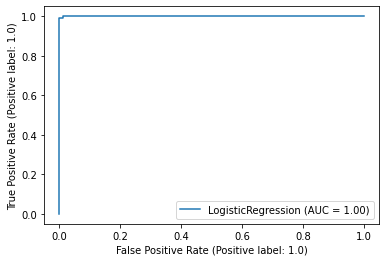

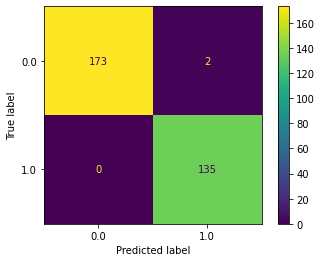

In [26]:
"""Logistic Regression"""
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report,accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=1)
lr = lr.fit(X_train, y_train)
y_pred4 = lr.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred4))
metrics.plot_roc_curve(lr, X_test, y_test)
cm=metrics.plot_confusion_matrix(lr, X_test, y_test)
print(metrics.confusion_matrix(y_test, y_pred4))
print(metrics.classification_report(y_test, y_pred4))
cm.figure_.savefig('LR.png',dpi=300)

In [27]:
print ('Accuracy:', accuracy_score(y_test, y_pred4))
print ('F1 score:', f1_score(y_test, y_pred4))
print ('Recall:', recall_score(y_test, y_pred4))
print ('Precision:', precision_score(y_test, y_pred4))

Accuracy: 0.9935483870967742
F1 score: 0.9926470588235294
Recall: 1.0
Precision: 0.9854014598540146


0.9935483870967742
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       175
         1.0       0.99      0.99      0.99       135

    accuracy                           0.99       310
   macro avg       0.99      0.99      0.99       310
weighted avg       0.99      0.99      0.99       310



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


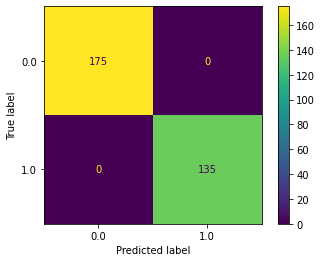

In [28]:

"""Random Forest Classifier"""

from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators=50, random_state=1)
RF = RF.fit(X_train, y_train)
y_pred5 = RF.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred5))
cm= metrics.plot_confusion_matrix(RF, X_test, y_pred5)
print(metrics.classification_report(y_test, y_pred5))
cm.figure_.savefig('RF.png',dpi=300)

In [29]:
print ('Accuracy:', accuracy_score(y_test, y_pred5))
print ('F1 score:', f1_score(y_test, y_pred5))
print ('Recall:', recall_score(y_test, y_pred5))
print ('Precision:', precision_score(y_test, y_pred5,))

Accuracy: 0.9935483870967742
F1 score: 0.9925925925925926
Recall: 0.9925925925925926
Precision: 0.9925925925925926


0.9967741935483871
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       175
         1.0       1.00      0.99      1.00       135

    accuracy                           1.00       310
   macro avg       1.00      1.00      1.00       310
weighted avg       1.00      1.00      1.00       310



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


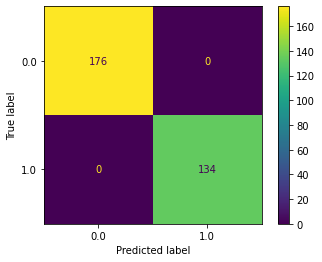

In [37]:
"""Ensemble Model"""

from sklearn.ensemble import VotingClassifier
voting_classifier = VotingClassifier(estimators=[('svm', svclassifier), ('dt', dt), ('lr', lr), ('rf', RF)], voting='soft')
voting_classifier.fit(X_train, y_train)
y_pred_vot = voting_classifier.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_vot))
#print("Acuracy score ", score*100)
cm= metrics.plot_confusion_matrix(voting_classifier, X_test, y_pred_vot)
print(metrics.classification_report(y_test, y_pred_vot))
cm.figure_.savefig('Ensemble.png',dpi=300)

In [38]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report,accuracy_score, f1_score
print ('Accuracy:', accuracy_score(y_test, y_pred_vot))
print ('F1 score:', f1_score(y_test, y_pred_vot))
print ('Recall:', recall_score(y_test, y_pred_vot))
print ('Precision:', precision_score(y_test, y_pred_vot,))

Accuracy: 0.9967741935483871
F1 score: 0.996282527881041
Recall: 0.9925925925925926
Precision: 1.0
